# Quick Overview

Most of the code presented here is for the python interface. Transposing the examples to bash should be quite straighforward since commands, options and functionalities should be almost identical between the command line interface and the python interface. 

## Introduction
The Copernicus Marine toolbox is a tool developed to connect users with marine data available at the [Copernicus Marine Data Store](https://data.marine.copernicus.eu/products). There, you can find products with relevant data for users.

One way to access this data is through the more visual tool [My Ocean Pro](https://data.marine.copernicus.eu/viewer/expert).

The Copernicus Marine toolbox allows access to this data programmatically and in an automated way, facilitating the download and distribution:
- [GitHub](https://github.com/mercator-ocean/copernicus-marine-toolbox)
- [Documentation](https://toolbox-docs.marine.copernicus.eu/)
- [Help Center](https://help.marine.copernicus.eu/en/)


The main functions (which we will explain later in more detail) are:
- Login: for authentication
- Describe: to get metadata from the Data Store
- Get: to download the native data
- Subset: to download specific (spatiotemporal) regions of interest

These four commands are available from the terminal (command line interface) and/or from a Python API (from scripts to notebooks!)


## Installation

There are different ways to use the Copernicus Marine toolbox, using the **`pip`** command, **`mamba | conda`**, the docker image or the binaries. You can see more information in the [installation page](installation-page) of the documentation.

### Check the Installation
To verify that it has been installed correctly, we can import the package from Python (or from the CLI) and see if it works properly.

In [1]:
import copernicusmarine
copernicusmarine.__version__

'1.3.3'

Once the package is installed, we can start to explore everything the toolbox has to offer.

## Copernicus Marine toolbox - Login

To register, you can obtain credentials for free by creating an account at [Copernicus Marine website](https://data.marine.copernicus.eu/register?redirect=%2Fproducts).

For more information, see the [page about login](login-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-login) or the {func}`python interface <copernicusmarine.login>`.

One of the ways to **save the credentials** (and then use the rest of the functionalities without having to think about it anymore) is with the `login` function. Indeed your credentials will be encoded and saved at `~/.copernicusmarine/.copernicusmarine-credentials`. You can change the folder using the `configuration_file_directory` argument.

In [ ]:
copernicusmarine.login(username='<your_username>', password='<your_password>')

You can also set environment variables for your processes, they are gonna be read by the `copernicusmarine.get` and `copernicusmarine.subset` automatically.

In [ ]:
# for Jupyter Notebook
%env COPERNICUSMARINE_SERVICE_USERNAME=<your_username>
%env COPERNICUSMARINE_SERVICE_PASSWORD=<your_password>

# for Python script
import os
os.environ['COPERNICUSMARINE_SERVICE_USERNAME'] = '<your_username>'
os.environ['COPERNICUSMARINE_SERVICE_PASSWORD'] = '<your_password>'

# for cli
!export COPERNICUSMARINE_SERVICE_USERNAME=<your_username>
!export COPERNICUSMARINE_SERVICE_PASSWORD=<your_password>

## Copernicus Marine toolbox - Describe

To explore the catalogue of products and datasets available in Copernicus Marine service.

For more information, see the [page about describe](describe-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-describe) or the {func}`python interface <copernicusmarine.describe>`.

In [3]:
# by default, we only get information about the products
catalogue_products = copernicusmarine.describe()
catalogue_products["products"][0]

Fetching catalog: 100%|██████████| 2/2 [00:11<00:00,  5.85s/it]


{'title': 'Antarctic Sea Ice Extent from Reanalysis',
 'product_id': 'ANTARCTIC_OMI_SI_extent',
 'thumbnail_url': 'https://catalogue.marine.copernicus.eu/documents/IMG/ANTARCTIC_OMI_SI_extent.png',
 'digital_object_identifier': '10.48670/moi-00186',
 'sources': ['Numerical models'],
 'processing_level': None,
 'production_center': 'Mercator Océan International'}

In [ ]:
# We can get information about the datasets
catalogue_datasets = copernicusmarine.describe(include_datasets=True)
# catalogue_datasets["products"][0]["datasets"][0] not shown because it is too long

In [10]:
# We can also filter based on the strings found by the describe method
copernicusmarine.describe(include_description=True, contains=["Iberian Biscay"])

Fetching catalog: 100%|██████████| 2/2 [00:12<00:00,  6.34s/it]


{'products': [{'title': 'Atlantic-Iberian Biscay Irish- Ocean Biogeochemical Analysis and Forecast',
   'product_id': 'IBI_ANALYSISFORECAST_BGC_005_004',
   'thumbnail_url': 'https://mdl-metadata.s3.waw3-1.cloudferro.com/metadata/thumbnails/IBI_ANALYSISFORECAST_BGC_005_004.jpg',
   'description': 'The IBI-MFC provides a high-resolution biogeochemical analysis and forecast product covering the European waters, and more specifically the Iberia–Biscay–Ireland (IBI) area. The last 2 years before now (historic best estimates) as well as daily averaged forecasts with a horizon of 10 days (updated on a weekly basis) are available on the catalogue.\nTo this aim, an online coupled physical-biogeochemical operational system is based on NEMO-PISCES at 1/36° and adapted to the IBI area, being Mercator-Ocean in charge of the model code development. PISCES is a model of intermediate complexity, with 24 prognostic variables. It simulates marine biological productivity of the lower trophic levels and 

Here is an example of a more exhaustive search:

In [11]:
# For a little more advanced search...
var_name = ["chl", "o2"]
regions = ["Iberian Biscay"]

# We find the products that offer the variables we are interested in:
describe_var = copernicusmarine.describe(contains=[var_name[0], var_name[1]])
prod_var = []
for product in describe_var['products']:
    prod_var.append(product['product_id'])
print(f"Products that offer the variables {var_name}: {len(prod_var)}")

# We save the products that offer the region we are interested in:
describe_loc = copernicusmarine.describe(contains=[regions[0]], include_all=True)
prod_loc = []
for product in describe_loc['products']:
    prod_loc.append(product['product_id'])
print(f"Products in the region {regions}: {len(prod_loc)}")

# And we search the intersection of both lists:
products = [prod_var, prod_loc]
final_selected_products = set.intersection(*map(set,products))

pairs_dataset_step = {}

for product in describe_loc['products']:
    # We add a filter to clarify specific products, in this case the "OMI" (Ocean Monitoring Indicators)
        if product['product_id'] in final_selected_products and "OMI_" not in product["product_id"]:
            for dataset in product['datasets']:
                for version in dataset['versions']:
                    for part in version['parts']:
                        for part in version.get('parts', []):
                            for service in part['services'][:-1]:
                            # And we filter the datasets that can be subsetted:
                                if 'arco-' in service['service_type']['service_name'] and 'zarr' in service['service_format']:
                                    for variable in service['variables']:
                                        if (variable['short_name'] == var_name[0], variable['short_name'] == var_name[1]) and variable['coordinates'] != []:
                                            pairs_dataset_step[dataset['dataset_id']] = (product['product_id'], variable['coordinates'][2]['step'])

for key, value in pairs_dataset_step.items():
    print("______________________")
    print(f"Product: {value[0]}")
    print(f"Dataset: {key}")
    print(f"Spatial resolution : {value[1]}")

Fetching catalog: 100%|██████████| 2/2 [00:11<00:00,  5.85s/it]


Products that offer the variables ['chl', 'o2']: 85


Fetching catalog: 100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


Products in the region ['Iberian Biscay']: 9
______________________
Product: IBI_ANALYSISFORECAST_BGC_005_004
Dataset: cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m
Spatial resolution : 0.027777777777777776
______________________
Product: IBI_ANALYSISFORECAST_BGC_005_004
Dataset: cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1M-m
Spatial resolution : 0.027777777777777776
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D-climatology_P1M-m
Spatial resolution : 0.08333333333333333
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D_P1D-m
Spatial resolution : 0.08333333333333333
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D_P1M-m
Spatial resolution : 0.08333333333333333
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D_P1Y-m
Spatial resolution : 0.08333333333333333


We see that Copernicus Marine has 2 high-resolution products (models) that cover the Bay of Biscay, both for chlorophyll and dissolved oxygen:
- [IBI_ANALYSISFORECAST_BGC_005_004](https://data.marine.copernicus.eu/product/IBI_ANALYSISFORECAST_BGC_005_004/description) with recent data and a few days of forecast
- [IBI_MULTIYEAR_BGC_005_003](https://data.marine.copernicus.eu/product/IBI_MULTIYEAR_BGC_005_003/description) with several years of data covering the last decades

Both products offer daily (`P1D`) and monthly (`P1M`) data.

## Copernicus Marine toolbox - Subset

For more information, see the [page about subset](subset-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-subset) or the {func}`python interface <copernicusmarine.subset>`.

The subset is a powerful tool that allow you to benefit from the power the Copernicus Marine services. Indeed, not only do you have access to the whole catalogue but you also can pinpoint the data that interest you thanks to the two services: "arco-geo-series" and "arco-time-series". They are respectively optimised for retieving maps (short time spam, wide area) and time series (long time span, small area). 

In [9]:
response_default_service = copernicusmarine.subset(
    dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
    variables=["chl", "o2"],
    maximum_longitude=-3,  
    minimum_longitude=-5,  
    minimum_latitude=43,   
    maximum_latitude=44,
    start_datetime="2023-09-01", end_datetime="2023-09-30", 
    file_format="netcdf",
    output_directory="data",
    force_download=True
) 

INFO - 2024-10-18T15:50:02Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-10-18T15:50:02Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-18T15:50:03Z - Service was not specified, the default one was selected: "arco-time-series"
INFO - 2024-10-18T15:50:05Z - Downloading using service arco-time-series...
INFO - 2024-10-18T15:50:06Z - Estimated size of the dataset file is 61.855 MB
Estimated size of the data that needs to be downloaded to obtain the result: 2814 MB
This is a very rough estimate that is generally higher than the actual size of the  data that needs to be downloaded.
INFO - 2024-10-18T15:50:06Z - Writing to local storage. Please wait...


  0%|          | 0/2802 [00:00<?, ?it/s]

INFO - 2024-10-18T15:50:17Z - Successfully downloaded to data/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_chl-o2_5.00W-3.00W_43.00N-44.00N_0.49-5727.92m_2023-09-01-2023-09-30_(1).nc


Let's try to use the other service to see the difference:

In [11]:
response = copernicusmarine.subset(
    dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
    variables=["chl", "o2"],
    maximum_longitude=-3,  
    minimum_longitude=-5,  
    minimum_latitude=43,   
    maximum_latitude=44,
    start_datetime="2023-09-01", end_datetime="2023-09-30", 
    file_format="netcdf",
    output_directory="data",
    force_download=True,
    dry_run=True, # Run without downloading anything
    service="arco-geo-series"
) 

print(f"arco-geo-series  would download a maximum {response.data_needed} B of data")
print(f"arco-time-series would download a maximum {response_default_service.data_needed} B of data")
# we can see that in this case, the arco-time-series is way more efficient (~10 times less data to download) for the same result

INFO - 2024-10-18T15:52:09Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-10-18T15:52:09Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-18T15:52:09Z - You forced selection of service: arco-geo-series
INFO - 2024-10-18T15:52:10Z - Downloading using service arco-geo-series...
INFO - 2024-10-18T15:52:12Z - Estimated size of the dataset file is 61.855 MB
Estimated size of the data that needs to be downloaded to obtain the result: 21414 MB
This is a very rough estimate that is generally higher than the actual size of the  data that needs to be downloaded.


arco-geo-series  would download a maximum 21413.702290076337 B of data
arco-time-series would download a maximum 2814.0458015267177 B of data


This downloaded file will be stored in the indicated local directory (or in the default one if none is specified). It can be downloaded in '.nc' or '.zarr' format. 

It can then be opened and used with the preferred method (in Python, Matlab, etc.) or software, such as [Panoply](https://www.giss.nasa.gov/tools/panoply/) and [QGIS](https://qgis.org/).

## Copernicus Marine toolbox - Open Dataset & Read Dataframe

Although the four main functions (`login`, `describe`, `subset`, and `get`) are available in the CLI and the API, the Python package also offers a series of additional functions: 
- `open_dataset()`: provides the ability to explore and retrieve data from Copernicus Marine services **remotely**, allowing users to specify various parameters to customize the returned object.

- `open_dataframe()`: facilitates **remote** manipulation and local extraction of data from Copernicus Marine using dataframes (e.g., CSV).

For more information, you can check the dedicated pages for the {func}`open_dataset <copernicusmarine.open_dataset>` function or the {func}`read_dataframe <copernicusmarine.read_dataframe>` function.


### General Dataset
We can view the data of the entire dataset:

In [14]:
# We open the dataset to explore the data:
data = copernicusmarine.open_dataset(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m")
data

INFO - 2024-10-18T12:48:42Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-10-18T12:48:42Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-18T12:48:44Z - Service was not specified, the default one was selected: "arco-geo-series"


<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 1081, longitude: 865, time: 1303)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 26.0 26.03 26.06 26.08 ... 55.94 55.97 56.0
  * longitude  (longitude) float32 -19.0 -18.97 -18.94 ... 4.944 4.972 5.0
  * time       (time) datetime64[ns] 2021-04-03 2021-04-04 ... 2024-10-26
Data variables: (12/14)
    chl        (time, depth, latitude, longitude) float32 ...
    dissic     (time, depth, latitude, longitude) float32 ...
    fe         (time, depth, latitude, longitude) float32 ...
    nh4        (time, depth, latitude, longitude) float32 ...
    no3        (time, depth, latitude, longitude) float32 ...
    nppv       (time, depth, latitude, longitude) float32 ...
    ...         ...
    phyc       (time, depth, latitude, longitude) float32 ...
    po4        (time, depth, latitude, longitude) float32 ...
    si         (time, depth, latitude, longitude) float32 ...
    spco2      (time, latitude, longitude) float32 ...
    zeu        (time, latitude, longitude) float32 ...
    zooc       (time, depth, latitude, longitude) float32 ...
Attributes:
    source:       NEMO3.6-PISCES3.6
    institution:  Nologin (Spain)
    title:        Biogeochemical 3D daily mean fields for the Iberia-Biscay-I...
    contact:      mailto: servicedesk.cmems@mercator-ocean.eu
    Conventions:  CF-1.0
    references:   http://marine.copernicus.eu/

The `open_dataset` function uses a lot of the subset functionalities to help you select the data directly and open lazily a dataset. If you want to process the data using directly xarray yourself you can, see [xarray's documentation](https://docs.xarray.dev/en/stable/).

In [3]:
import datetime
# Now we can focus on the paraeteers that we are interested in: the region of Cantabria, with a specific dates.
response_bay = copernicusmarine.open_dataset(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
                        variables=["chl", "o2"],
                        maximum_longitude=-3,  # Sopela, to the right
                        minimum_longitude=-5,  # Llanes, to the left
                        minimum_latitude=43,   # 85km inside the sea
                        maximum_latitude=44,   # Santander
                        start_datetime=datetime.datetime.now()-datetime.timedelta(days=2), 
                        end_datetime=datetime.datetime.now()+datetime.timedelta(days=4))
response_bay

INFO - 2024-10-18T16:08:46Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-10-18T16:08:46Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-18T16:08:47Z - Service was not specified, the default one was selected: "arco-time-series"


<xarray.Dataset> Size: 13MB
Dimensions:    (depth: 50, latitude: 37, longitude: 73, time: 6)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 148B 43.0 43.03 43.06 ... 43.94 43.97 44.0
  * longitude  (longitude) float32 292B -5.0 -4.972 -4.944 ... -3.028 -3.0
  * time       (time) datetime64[ns] 48B 2024-10-17 2024-10-18 ... 2024-10-22
Data variables:
    chl        (time, depth, latitude, longitude) float64 6MB ...
    o2         (time, depth, latitude, longitude) float64 6MB ...
Attributes:
    institution:  Nologin (Spain)
    contact:      mailto: servicedesk.cmems@mercator-ocean.eu
    Conventions:  CF-1.0
    title:        Biogeochemical 3D daily mean fields for the Iberia-Biscay-I...
    references:   http://marine.copernicus.eu/
    source:       NEMO3.6-PISCES3.6

In [5]:
# I can not see all the values of the dataset without downloading it
# For the time dimension for example:
response_bay.time.values

array(['2024-10-17T00:00:00.000000000', '2024-10-18T00:00:00.000000000',
       '2024-10-19T00:00:00.000000000', '2024-10-20T00:00:00.000000000',
       '2024-10-21T00:00:00.000000000', '2024-10-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

Let's use `xarray` and `matplotlib` to plot our data.

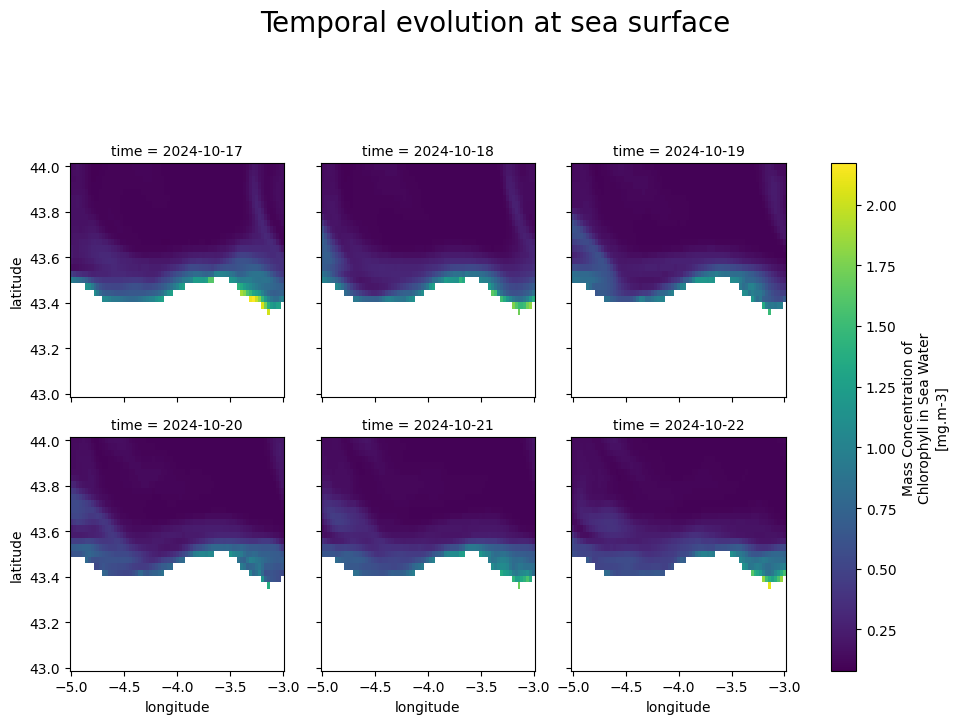

In [4]:
import matplotlib.pyplot as plt
import xarray

response_bay["chl"].isel(depth=10).plot(col="time", col_wrap=3)
plt.suptitle("Temporal evolution at sea surface", fontsize=20, y=1.2)
plt.show()

## Copernicus Marine toolbox - Get

To download the original data (or native data), you can use the **`get`** command.

For more information, see the [page about get](get-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-get) or the {func}`python interface <copernicusmarine.get>`.



In [ ]:
# Download all the files from a dataset
copernicusmarine.get(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m") 

INFO - 2024-10-18T14:48:09Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-10-18T14:48:09Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-18T14:48:09Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-10-18T14:48:09Z - Downloading using service original-files...
INFO - 2024-10-18T14:48:10Z - Listing files on remote server...
1it [00:00,  1.09it/s]
INFO - 2024-10-18T14:48:11Z - You requested the download of the following files:
s3://mdl-native-10/native/IBI_ANALYSISFORECAST_BGC_005_004/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_202211/2022/10/CMEMS_v7r1_IBI_BIO_NRT_NL_01dav_20221001_20221001_R20221017_AN04.nc - 82.48 MB - 2023-11-12T14:01:32.377000Z
s3://mdl-native-10/native/IBI_ANALYSISFORECAST_BGC_005_004/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_202211/2022/10/CMEMS_v7r1_IBI_BIO_NRT_NL_01dav_20221002_20221002_R20221017_AN05.nc - 82.77 MB - 2023-11-12T14:01:38.666000Z
s3:

In [14]:
# You can combine the filter and regex argument (it will be as an "OR" condition)
response = copernicusmarine.get(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
                     filter="*01dav_20221001_20221001_R20221017_AN04*", 
                     regex="01dav_20221003_20221003_R20221017_AN06", 
                     force_download=True, # no need to prompt
                     output_directory="data", # we can specify the output directory
                     overwrite_output_data=True, # if files already exist, they will be overwritten
                     )

for file_metadata in response.files:
    print(file_metadata.output) 

INFO - 2024-10-18T15:19:27Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-10-18T15:19:27Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-18T15:19:27Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-10-18T15:19:27Z - Downloading using service original-files...
INFO - 2024-10-18T15:19:27Z - Listing files on remote server...
1it [00:00,  1.90it/s]

data/IBI_ANALYSISFORECAST_BGC_005_004/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_202211/2022/10/CMEMS_v7r1_IBI_BIO_NRT_NL_01dav_20221001_20221001_R20221017_AN04.nc
data/IBI_ANALYSISFORECAST_BGC_005_004/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_202211/2022/10/CMEMS_v7r1_IBI_BIO_NRT_NL_01dav_20221003_20221003_R20221017_AN06.nc


Now if you have download this data, but you want to check if you data is up to data you can use the `sync` option. 

In [15]:
response = copernicusmarine.get(
    dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
    filter="*01dav_20221001_20221001_R20221017_AN04*", 
    regex="01dav_20221003_20221003_R20221017_AN06",  
    dataset_version="202211", 
    force_download=True,
    output_directory="data",
    sync=True,
    sync_delete=True, # delete the files that are not in the server
    max_concurrent_requests=0, # not in parallel
    # can be useful to be sure to not overload the process 
)

INFO - 2024-10-18T15:20:33Z - You forced selection of dataset version "202211"
INFO - 2024-10-18T15:20:33Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-18T15:20:33Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-10-18T15:20:33Z - Downloading using service original-files...
INFO - 2024-10-18T15:20:33Z - Listing files on remote server...
1it [00:00,  1.91it/s]
INFO - 2024-10-18T15:20:33Z - No data to download
